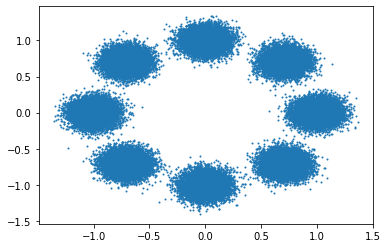

In [5]:
import torch
import torch.nn.functional as nn
import torch.autograd as autograd
import random
import torch.nn.init as init
import torch.optim as optim
import numpy as np
import matplotlib.pyplot as plt
import torchvision
from torchvision import datasets, transforms
from torch.utils.data import DataLoader


class CustomDataSet(torch.utils.data.Dataset):

    def __init__(self, n_group, n_data):

        self.n_group = n_group
        self.n_data = n_data
        _data = np.random.randn(self.n_data, 2)
        _label = np.ndarray(self.n_data, dtype=np.int)
        _mu = []
        _sig = 0.1
        for k in range(n_group):
            _mu.append([np.cos(2.0 * np.pi * k / n_group), np.sin(2.0 * np.pi * k / n_group)])
        for i in range(n_data):
            _data[i][0] = _sig * _data[i][0] + _mu[i % n_group][0]
            _data[i][1] = _sig * _data[i][1] + _mu[i % n_group][1]
            _label[i] = i % n_group

        self.data = torch.as_tensor(_data, dtype=torch.float32)
        self.label = torch.as_tensor(_label, dtype=torch.int64)

    def __len__(self):
        return self.n_data

    def __getitem__(self, idx):
        # return self.data[idx], self.label[idx]
        return self.data[idx]


data_size = 80000
dataset = CustomDataSet(n_group=8, n_data=data_size)

data_points = dataset.data.numpy()
plt.scatter(data_points[:, 0], data_points[:, 1], s=1)
plt.show()

In [9]:
device = 'cuda' if torch.cuda.is_available() else 'cpu'
random.seed(111)
torch.manual_seed(777)
if device == 'cuda': 
    torch.cuda.manual_seed_all(777)
print(device)

cpu


In [26]:
def reparametrize(mu, sig):
    eps = torch.randn_like(sig).to(device)
    return mu + sig*eps


def reverseKL_STD(mu, sig):
    reverse_kl = -torch.log(sig) + ((sig * sig + mu * mu) / 2.0) - 0.5
    return torch.mean(reverse_kl)


def KLD(sampler_mu, sampler_sig, mu, sig): #KL(N(self.mu, self.sig) || N(tar_mu, tar_sig))
    kld = torch.log(sig) - torch.log(sampler_sig) + ((sampler_sig * sampler_sig + (sampler_mu - mu) * (sampler_mu - mu)) / (2.0 * sig * sig)) - 0.5
    return torch.mean(kld)


def log_likelihood(x, mu, sig): # Factorized Normal distribution
    return -torch.mean(torch.log(sig) + 0.5 * (np.log(2.0 * np.pi) + ((mu - x)/sig)**2))


def permute_dims(z):
    assert z.dim() == 2
    mb_size, _ = z.size()
    perm_z = []
    for z_j in z.split(1, 1):
        perm = torch.randperm(mb_size).to(z.device)
        perm_z_j = z_j[perm]
        perm_z.append(perm_z_j)
    return torch.cat(perm_z, 1)


class View(torch.nn.Module):
    def __init__(self, size):
        super(View, self).__init__()
        self.size = size

    def forward(self, tensor):
        return tensor.view(self.size)


class Discriminator(torch.nn.Module):
    def __init__(self):
        super(Discriminator, self).__init__()
        self.z_dim = 2
        self.net = torch.nn.Sequential(
            torch.nn.Linear(self.z_dim, 32),
            torch.nn.LeakyReLU(0.2, True),
            torch.nn.Linear(32, 32),
            torch.nn.LeakyReLU(0.2, True),
            torch.nn.Linear(32, 32),
            torch.nn.LeakyReLU(0.2, True),
            torch.nn.Linear(32, 1),
            torch.nn.Sigmoid()
        ).to(device)
        self.weight_init()

    def weight_init(self):
        for block in self._modules:
            for m in self._modules[block]:
                kaiming_init(m)

    def forward(self, z):
        return self.net(z)


class VAE(torch.nn.Module):
    """TEST MODEL FOR DSPRITES DATASET"""

    def __init__(self):
        super(VAE, self).__init__()
        self.x_dim = 2
        self.z_dim = 2
        self.encoder = torch.nn.Sequential(
            torch.nn.Linear(self.x_dim, 32),
            torch.nn.ReLU(True),
            torch.nn.Linear(32, 32),
            torch.nn.ReLU(True),
            torch.nn.Linear(32, 32),
            torch.nn.ReLU(True),
            torch.nn.Linear(32, self.z_dim*2)
        ).to(device)


        self.decoder = torch.nn.Sequential(
            torch.nn.Linear(self.z_dim, 32),
            torch.nn.ReLU(True),
            torch.nn.Linear(32, 32),
            torch.nn.ReLU(True),
            torch.nn.Linear(32, 32),
            torch.nn.ReLU(True),
            torch.nn.Linear(32, self.x_dim * 2)
        ).to(device)
        self.weight_init()

    def weight_init(self):
        for block in self._modules:
            for m in self._modules[block]:
                kaiming_init(m)

    def encode(self, x):
        qzx = self.encoder(x)
        qzx_mu = qzx[:, :self.z_dim]
        qzx_log_var = qzx[:, self.z_dim:]
        qzx_sig = torch.exp(0.5 * qzx_log_var)
        return qzx_mu, qzx_sig

    def decode(self, z):
        pxz = self.decoder(z)
        pxz_mu = pxz[:, :self.x_dim]
        pxz_log_var = pxz[:, self.x_dim:]
        pxz_sig = torch.exp(0.5 * pxz_log_var)
        return pxz_mu, pxz_sig 

    def forward(self, x):
        qzx_mu, qzx_sig = self.encode(x)
        pxz_mu, pxz_sig = self.decode(reparametrize(qzx_mu, qzx_sig))
        return qzx_mu, qzx_sig, pxz_mu, pxz_sig



def kaiming_init(m):
    if isinstance(m, (torch.nn.Linear, torch.nn.Conv2d)):
        init.kaiming_normal_(m.weight)
        if m.bias is not None:
            m.bias.data.fill_(0)
    elif isinstance(m, (torch.nn.BatchNorm1d, torch.nn.BatchNorm2d)):
        m.weight.data.fill_(1)
        if m.bias is not None:
            m.bias.data.fill_(0)

In [27]:
mb_size = 32
loader = torch.utils.data.DataLoader(dataset=dataset,
                                     batch_size=mb_size,
                                     shuffle=True,
                                     drop_last=True)


vae = VAE()
vae_solver = optim.Adam(vae.parameters(), lr=1e-4)
discriminator = Discriminator()
discriminator_solver = optim.Adam(discriminator.parameters(), lr=1e-4)
ones = torch.ones(mb_size, 1)
zeros = torch.zeros(mb_size, 1)
X_DIM = 2
Z_DIM = 2

In [52]:
num_epochs = 1
beta = 1.0
gamma = 1.0
prior_kld = torch.zeros(Z_DIM, dtype=torch.float, requires_grad=False).to(device)
for epoch in range(num_epochs):
    RECON_AVG = 0.0
    IBC_AVG = 0.0
    prior_kld.fill_(0)
    for _, X in enumerate(loader):


        vae_solver.zero_grad()
        z_mu, z_sig, x_mu, x_sig = vae(X)
        ibc = reverseKL_STD(z_mu, z_sig) * Z_DIM
        recon_loss = -log_likelihood(X, x_mu, x_sig) * X_DIM
        adversarial_loss = torch.nn.functional.binary_cross_entropy(discriminator(reparametrize(z_mu, z_sig)), ones)
        loss = recon_loss + beta * ibc + gamma * adversarial_loss
        loss.backward()
        vae_solver.step()


        discriminator_solver.zero_grad()
        d_real = discriminator(permute_dims(reparametrize(z_mu, z_sig).detach()))
        d_fake = discriminator(reparametrize(z_mu, z_sig).detach())
        D_loss_real = nn.binary_cross_entropy(d_real, ones)
        D_loss_fake = nn.binary_cross_entropy(d_fake, zeros)
        (D_loss_real + D_loss_fake).backward()
        discriminator_solver.step()


        prior_kld += torch.mean(-torch.log(z_sig) + ((z_sig * z_sig + z_mu * z_mu) / 2.0) - 0.5, dim=0)

 
        RECON_AVG += recon_loss.item()
        IBC_AVG += ibc.item() 

    
    RECON_AVG /= (len(loader) * X_DIM)
    IBC_AVG /= (len(loader) * Z_DIM)
    print(epoch, 'beta:', beta, 'RECON:', RECON_AVG, 'IBC', IBC_AVG)
    print('kld : ', prior_kld.cpu().detach().numpy() / len(loader))

0 beta: 1.0 RECON: -1.774938115620613 IBC 2.0802534989356993
kld :  [2.1420224 2.0184846]


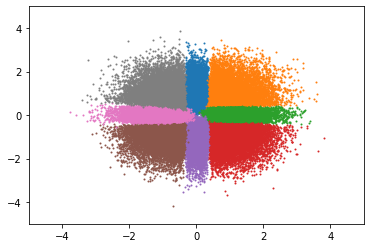

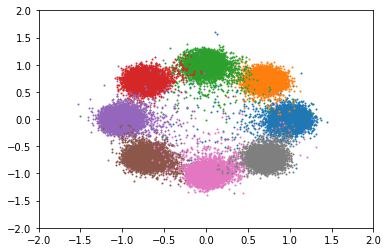

In [53]:
group = []
for k in range(dataset.n_group):
    group.append([])
np_data = dataset.data.numpy()
np_label = dataset.label.numpy()

for i in range(data_size):
    group[np_label[i]].append(np_data[i])

group = np.array(group)

for k in range(dataset.n_group):
    z_mu, z_sig, x_mu, x_sig = vae(torch.from_numpy(group[k]))
    z = reparametrize(z_mu, z_sig).detach().numpy()
    plt.scatter(z[:,0], z[:,1], s=1)
plt.xlim(-5, 5)
plt.ylim(-5, 5)
plt.show()

for k in range(dataset.n_group):
    z_mu, z_sig, x_mu, x_sig = vae(torch.from_numpy(group[k]))
    x = reparametrize(x_mu, x_sig).detach().numpy()
    plt.scatter(x[:,0], x[:,1], s=1)
plt.xlim(-2, 2)
plt.ylim(-2, 2)
plt.show()